In [1]:
import numpy as np
import pandas as pd
import re

from collections import Counter
import csv
import time
import json

import seaborn as sns

from nltk.stem import WordNetLemmatizer
from sklearn.metrics.pairwise import cosine_similarity

from wordcloud import WordCloud
import matplotlib.pyplot as plt


In [2]:

def return_max_index(corr_mat):
    res_max = {}
    for i, r in enumerate(corr_mat.index):
        tmp = corr_mat[r]
        tmp[r] = 0
        max_index = tmp.idxmax()
        res_max[r] = (max_index, tmp[max_index])
    return res_max

def return_max_column(corr_mat):
    res_max = {}
    for i, r in enumerate(corr_mat.index):
        tmp = corr_mat.loc[r]
        tmp[r] = 0
        max_index = tmp.idxmax()
        res_max[r] = (max_index, tmp[max_index])
    return res_max

def return_largest_n_column(m, n):
    corr_mat = m.copy()
    res_max = {}
    for i, r in enumerate(corr_mat.index):
        tmp = corr_mat.loc[r]
        tmp[r] = 0
        res_max[r] = tmp[sorted(range(len(tmp)), key=lambda k: tmp[k], reverse=True)[:n]].to_dict()
    return res_max

In [3]:
'''
    Calculate similarity matrix
    
'''

def get_sim_and_conf_mat(sub_data, category, combine_feature):
    start_time = time.time()

    tmp_df = sub_data.copy()
    print('Dimension of the item-level dataset: {}'.format(tmp_df.shape))

    tmp_df = tmp_df[~tmp_df['level_3'].isnull()]
    del_category = tmp_df['level_3'].value_counts()[tmp_df['level_3'].value_counts() < 10].index
    print('Filtering out level-3 categories with less than 10 records: {}'.format(del_category.values))

    if len(del_category) > 0:
        tmp_df = tmp_df[~tmp_df['level_3'].isin(del_category)]

    print('Dimension of the item-level dataset after removing level_3 = NULL and less than 10 records: {}'.format(tmp_df.shape))

    feature_list = sorted(tmp_df['level_3'].unique())
    n_feature = len(feature_list)
    print('Number of unique features: {}'.format(n_feature))

    tmp_group = tmp_df.groupby('UUID').agg({'level_3': list}).reset_index()
    print('Dimension of the user-level dataset: {}'.format(tmp_group.shape))

    if category == 'restaurant' and combine_feature == True:
        print('Category: {} and combine feature groups: (Pizza, Italian), (Sushi, Japanese), \
              (Chinese, Asian), (Japanese, Asian), (Thai, Asian), (Korean, Asian)'.format(category))
        for i in range(tmp_group.shape[0]):
            if 'Pizza' in tmp_group['level_3'][i]:
                tmp_group['level_3'][i].append('Italian Restaurants')
            if 'Sushi' in tmp_group['level_3'][i]:
                tmp_group['level_3'][i].append('Japanese Restaurants')
            if 'Chinese Restaurants' in tmp_group['level_3'][i]:
                tmp_group['level_3'][i].append('Asian Restaurants')
            if  'Japanese Restaurants' in tmp_group['level_3'][i]:
                tmp_group['level_3'][i].append('Asian Restaurants')
            if  'Thai Restaurants' in tmp_group['level_3'][i]:
                tmp_group['level_3'][i].append('Asian Restaurants')
            if  'Korean Restaurants' in tmp_group['level_3'][i]:
                tmp_group['level_3'][i].append('Asian Restaurants')

    # 1. symmetric similarity matrix: Supp(x)
    sim_mat = np.zeros((n_feature, n_feature))

    # 2. asymmetric confidence matrix: Conf(X->Y)
    conf_mat = np.zeros((n_feature, n_feature))

    n_users = tmp_group.shape[0]
    print('Total number of users: {}'.format(n_users))
    
    for r in range(sim_mat.shape[0]):
        fr = feature_list[r]
        tmp_time = time.time()
        print(fr)

        for c in range(sim_mat.shape[0]):
            if r != c:
                fc = feature_list[c]

                supp_fr_and_fc = 0
                supp_fr_or_fc = 0
                supp_fr = 0
                for i in range(tmp_group.shape[0]):
                    supp_fr_and_fc += int((fr in tmp_group['level_3'][i])&(fc in tmp_group['level_3'][i]))
                    supp_fr_or_fc += int((fr in tmp_group['level_3'][i])|(fc in tmp_group['level_3'][i]) )

                    supp_fr += int(fr in tmp_group['level_3'][i])

    #             supp_fr_fc = sum([int(fr in tmp_group['level_3'][i] and fc in tmp_group['level_3'][i]) \
    #                                              for i in range(tmp_group.shape[0])])
    #             supp_fr = sum([int(fr in tmp_group['level_3'][i]) for i in range(tmp_group.shape[0])])
                
                print('Intersection of {} and {}: {}'.format(fr, fc, supp_fr_and_fc))
                print('Union of {} and {}: {}'.format(fr, fc, supp_fr_or_fc))
                print('# of users of {}: {}'.format(fr, supp_fr), '\n')

                # 1. similarity matrix: Jaccard
                sim_mat[r, c] = round(supp_fr_and_fc/supp_fr_or_fc, 6)

                # 2. confidence matrix: 
                conf_mat[r, c] = round(supp_fr_and_fc/supp_fr, 6)
        print('Completed row {} for {}s'.format(fr, round(time.time() - tmp_time, 2)), '\n')

    # fill diagonal with 1s
    np.fill_diagonal(sim_mat, 1)
    np.fill_diagonal(conf_mat, 1)            

    sim_mat = pd.DataFrame(sim_mat, index=feature_list, columns=feature_list)
    conf_mat = pd.DataFrame(conf_mat, index=feature_list, columns=feature_list)

    print('Running time: {}s'.format(round(time.time() - start_time ,2)))
    
    return sim_mat, conf_mat, tmp_group


In [4]:
anon_data = pd.read_csv('anon_data.tsv', sep = '\t', index_col=0)
print(anon_data.shape)

print('unique UUID: {}'.format(len(anon_data['UUID'].unique())))

anon_data.head()

(999342, 8)
unique UUID: 54449


UUID                              Category Taxonomy  \
0  28535  Food, Beverages & Tobacco>Food Items      GPT   
1  28535        Food & Drink>Restaurants>Pizza  Groupon   
2  28535        Food & Drink>Restaurants>Pizza  Groupon   
3  28535        Food & Drink>Restaurants>Pizza  Groupon   
4  28535        Food & Drink>Restaurants>Pizza  Groupon   

                                         ProductName          Seller Currency  \
0  Halls Sugar-Free Cough Drops , Honey Lemon ( 1...     Sam 's Club      USD   
1                                Philly Cheese Steak  Domino's Pizza      USD   
2                     Medium (12") Hand Tossed Pizza  Domino's Pizza    #NULL   
3                Specialty Chicken – Sweet BBQ Bacon  Domino's Pizza      USD   
4                     Medium (12") Hand Tossed Pizza  Domino's Pizza      USD   

   AcceptedOfferPrice  OfferPrice  
0                7.33        6.87  
1               20.00        5.99  
2                6.67        0.00  
3               20.00        5.99  
4               25.77        5.99

Food and Drink Google Taxonomy

In [5]:
'''
    Read Google taxonomy dataset
'''
anon_data['Category'] = anon_data['Category'].map(lambda x: x.replace(' ', ''))

googleTaxonomy = pd.read_csv('Food and Drink Taxonomy - yo_Groogle Taxonomy.csv', 
                            names=['Taxonomy', 'id', 'Category', 'empty_1', 'level_1', 'level_2', 'level_3',
                                  'empty_2', 'empty_3', 'empty_4'])
googleTaxonomy.drop(['empty_1', 'empty_2', 'empty_3', 'empty_4'], axis = 1, inplace = True)
googleTaxonomy['Category'] = googleTaxonomy['Category'].map(lambda x: x.replace(' ', ''))
print(googleTaxonomy.shape)

googleTaxonomy.head()

(403, 6)


Taxonomy      id                     Category       level_1 level_2  \
0  Groupon  603000                   Food&Drink  Food & Drink     NaN   
1  Groupon  603001              Food&Drink>Bars  Food & Drink    Bars   
2  Groupon  603002     Food&Drink>Bars>DiveBars  Food & Drink    Bars   
3  Groupon  603003  Food&Drink>Bars>KaraokeBars  Food & Drink    Bars   
4  Groupon  603004      Food&Drink>Bars>Lounges  Food & Drink    Bars   

        level_3  
0           NaN  
1           NaN  
2     Dive Bars  
3  Karaoke Bars  
4       Lounges

In [6]:
'''
    Combine transaction dataset and Google taxonomy

'''

anon_data = pd.merge(anon_data, googleTaxonomy[['Category', 'level_1', 'level_2', 'level_3']],
                    how = 'left', on = 'Category')
print(anon_data.shape)

anon_data.head()

(999342, 11)


UUID                          Category Taxonomy  \
0  28535  Food,Beverages&Tobacco>FoodItems      GPT   
1  28535      Food&Drink>Restaurants>Pizza  Groupon   
2  28535      Food&Drink>Restaurants>Pizza  Groupon   
3  28535      Food&Drink>Restaurants>Pizza  Groupon   
4  28535      Food&Drink>Restaurants>Pizza  Groupon   

                                         ProductName          Seller Currency  \
0  Halls Sugar-Free Cough Drops , Honey Lemon ( 1...     Sam 's Club      USD   
1                                Philly Cheese Steak  Domino's Pizza      USD   
2                     Medium (12") Hand Tossed Pizza  Domino's Pizza    #NULL   
3                Specialty Chicken – Sweet BBQ Bacon  Domino's Pizza      USD   
4                     Medium (12") Hand Tossed Pizza  Domino's Pizza      USD   

   AcceptedOfferPrice  OfferPrice                    level_1      level_2  \
0                7.33        6.87  Food, Beverages & Tobacco   Food Items   
1               20.00        5.99               Food & Drink  Restaurants   
2                6.67        0.00               Food & Drink  Restaurants   
3               20.00        5.99               Food & Drink  Restaurants   
4               25.77        5.99               Food & Drink  Restaurants   

  level_3  
0     NaN  
1   Pizza  
2   Pizza  
3   Pizza  
4   Pizza

Split the dataset into two subsets:
- level_2: Restaurants, Bars, Cafes&Treats
- level_2: all others -> Grocery data

In [7]:
'''
    - Restaurants, Bars, Cafes & Treats

'''
restaurants_data = anon_data[anon_data['level_2'].isin(['Restaurants', 'Bars', 'Cafes & Treats'])].reset_index(drop=True)
print(restaurants_data.shape)

restaurants_data.head()

(298398, 11)


UUID                      Category Taxonomy  \
0  28535  Food&Drink>Restaurants>Pizza  Groupon   
1  28535  Food&Drink>Restaurants>Pizza  Groupon   
2  28535  Food&Drink>Restaurants>Pizza  Groupon   
3  28535  Food&Drink>Restaurants>Pizza  Groupon   
4  28535  Food&Drink>Restaurants>Pizza  Groupon   

                           ProductName          Seller Currency  \
0                  Philly Cheese Steak  Domino's Pizza      USD   
1       Medium (12") Hand Tossed Pizza  Domino's Pizza    #NULL   
2  Specialty Chicken – Sweet BBQ Bacon  Domino's Pizza      USD   
3       Medium (12") Hand Tossed Pizza  Domino's Pizza      USD   
4                        2-Liter Coke®  Domino's Pizza      USD   

   AcceptedOfferPrice  OfferPrice       level_1      level_2 level_3  
0               20.00        5.99  Food & Drink  Restaurants   Pizza  
1                6.67        0.00  Food & Drink  Restaurants   Pizza  
2               20.00        5.99  Food & Drink  Restaurants   Pizza  
3               25.77        5.99  Food & Drink  Restaurants   Pizza  
4               25.77        2.89  Food & Drink  Restaurants   Pizza

In [10]:
sim_mat_restaurant, \
conf_mat_restaurant, \
tmp_group_restaurant = get_sim_and_conf_mat(restaurants_data, category='restaurant', combine_feature=False)

Dimension of the item-level dataset: (298398, 11)
Filtering out level-3 categories with less than 10 records: []
Dimension of the item-level dataset after removing level_3 = NULL and less than 10 records: (228749, 11)
Number of unique features: 29
Dimension of the user-level dataset: (38282, 2)
Total number of users: 38282
American Restaurants
Intersection of American Restaurants and Asian Restaurants: 1696
Union of American Restaurants and Asian Restaurants: 16623
# of users of American Restaurants: 14910 

Intersection of American Restaurants and BBQ Restaurants: 434
Union of American Restaurants and BBQ Restaurants: 15215
# of users of American Restaurants: 14910 

Intersection of American Restaurants and Bakeries: 1330
Union of American Restaurants and Bakeries: 16085
# of users of American Restaurants: 14910 

Intersection of American Restaurants and Bar Food: 914
Union of American Restaurants and Bar Food: 15370
# of users of American Restaurants: 14910 

Intersection of American

Intersection of Asian Restaurants and Sandwiches: 967
Union of Asian Restaurants and Sandwiches: 10857
# of users of Asian Restaurants: 3409 

Intersection of Asian Restaurants and Seafood Restaurants: 320
Union of Asian Restaurants and Seafood Restaurants: 4402
# of users of Asian Restaurants: 3409 

Intersection of Asian Restaurants and Steakhouse: 35
Union of Asian Restaurants and Steakhouse: 3636
# of users of Asian Restaurants: 3409 

Intersection of Asian Restaurants and Sushi: 386
Union of Asian Restaurants and Sushi: 4113
# of users of Asian Restaurants: 3409 

Intersection of Asian Restaurants and Thai Restaurants: 374
Union of Asian Restaurants and Thai Restaurants: 3816
# of users of Asian Restaurants: 3409 

Intersection of Asian Restaurants and Vegetarian Restaurants: 13
Union of Asian Restaurants and Vegetarian Restaurants: 3442
# of users of Asian Restaurants: 3409 

Completed row Asian Restaurants for 120.89s 

BBQ Restaurants
Intersection of BBQ Restaurants and America

Intersection of Bakeries and Thai Restaurants: 80
Union of Bakeries and Thai Restaurants: 3206
# of users of Bakeries: 2505 

Intersection of Bakeries and Vegetarian Restaurants: 7
Union of Bakeries and Vegetarian Restaurants: 2544
# of users of Bakeries: 2505 

Completed row Bakeries for 121.15s 

Bar Food
Intersection of Bar Food and American Restaurants: 914
Union of Bar Food and American Restaurants: 15370
# of users of Bar Food: 1374 

Intersection of Bar Food and Asian Restaurants: 201
Union of Bar Food and Asian Restaurants: 4582
# of users of Bar Food: 1374 

Intersection of Bar Food and BBQ Restaurants: 61
Union of Bar Food and BBQ Restaurants: 2052
# of users of Bar Food: 1374 

Intersection of Bar Food and Bakeries: 154
Union of Bar Food and Bakeries: 3725
# of users of Bar Food: 1374 

Intersection of Bar Food and British Restaurants: 4
Union of Bar Food and British Restaurants: 1442
# of users of Bar Food: 1374 

Intersection of Bar Food and Burgers: 410
Union of Bar Food 

Intersection of Burgers and Asian Restaurants: 941
Union of Burgers and Asian Restaurants: 10856
# of users of Burgers: 8388 

Intersection of Burgers and BBQ Restaurants: 234
Union of Burgers and BBQ Restaurants: 8893
# of users of Burgers: 8388 

Intersection of Burgers and Bakeries: 735
Union of Burgers and Bakeries: 10158
# of users of Burgers: 8388 

Intersection of Burgers and Bar Food: 410
Union of Burgers and Bar Food: 9352
# of users of Burgers: 8388 

Intersection of Burgers and British Restaurants: 16
Union of Burgers and British Restaurants: 8444
# of users of Burgers: 8388 

Intersection of Burgers and Cafes: 251
Union of Burgers and Cafes: 8905
# of users of Burgers: 8388 

Intersection of Burgers and Chinese Restaurants: 1142
Union of Burgers and Chinese Restaurants: 11271
# of users of Burgers: 8388 

Intersection of Burgers and Coffee Shops: 302
Union of Burgers and Coffee Shops: 8925
# of users of Burgers: 8388 

Intersection of Burgers and Diners: 309
Union of Burger

Intersection of Chinese Restaurants and Ice Cream: 18
Union of Chinese Restaurants and Ice Cream: 4089
# of users of Chinese Restaurants: 4025 

Intersection of Chinese Restaurants and Indian Restaurants: 416
Union of Chinese Restaurants and Indian Restaurants: 5290
# of users of Chinese Restaurants: 4025 

Intersection of Chinese Restaurants and Italian Restaurants: 668
Union of Chinese Restaurants and Italian Restaurants: 7352
# of users of Chinese Restaurants: 4025 

Intersection of Chinese Restaurants and Japanese Restaurants: 522
Union of Chinese Restaurants and Japanese Restaurants: 4828
# of users of Chinese Restaurants: 4025 

Intersection of Chinese Restaurants and Korean Restaurants: 33
Union of Chinese Restaurants and Korean Restaurants: 4076
# of users of Chinese Restaurants: 4025 

Intersection of Chinese Restaurants and Latin American Restaurants: 252
Union of Chinese Restaurants and Latin American Restaurants: 4322
# of users of Chinese Restaurants: 4025 

Intersection o

Intersection of Diners and Japanese Restaurants: 51
Union of Diners and Japanese Restaurants: 1784
# of users of Diners: 510 

Intersection of Diners and Korean Restaurants: 8
Union of Diners and Korean Restaurants: 586
# of users of Diners: 510 

Intersection of Diners and Latin American Restaurants: 60
Union of Diners and Latin American Restaurants: 999
# of users of Diners: 510 

Intersection of Diners and Mediterranean Restaurants: 9
Union of Diners and Mediterranean Restaurants: 879
# of users of Diners: 510 

Intersection of Diners and Mexican Restaurants: 251
Union of Diners and Mexican Restaurants: 5819
# of users of Diners: 510 

Intersection of Diners and Middle Eastern Restaurants: 6
Union of Diners and Middle Eastern Restaurants: 1008
# of users of Diners: 510 

Intersection of Diners and Pizza: 235
Union of Diners and Pizza: 19245
# of users of Diners: 510 

Intersection of Diners and Pubs: 0
Union of Diners and Pubs: 857
# of users of Diners: 510 

Intersection of Diners 

Intersection of Ice Cream and Middle Eastern Restaurants: 1
Union of Ice Cream and Middle Eastern Restaurants: 585
# of users of Ice Cream: 82 

Intersection of Ice Cream and Pizza: 44
Union of Ice Cream and Pizza: 19008
# of users of Ice Cream: 82 

Intersection of Ice Cream and Pubs: 36
Union of Ice Cream and Pubs: 393
# of users of Ice Cream: 82 

Intersection of Ice Cream and Sandwiches: 30
Union of Ice Cream and Sandwiches: 8467
# of users of Ice Cream: 82 

Intersection of Ice Cream and Seafood Restaurants: 9
Union of Ice Cream and Seafood Restaurants: 1386
# of users of Ice Cream: 82 

Intersection of Ice Cream and Steakhouse: 0
Union of Ice Cream and Steakhouse: 344
# of users of Ice Cream: 82 

Intersection of Ice Cream and Sushi: 7
Union of Ice Cream and Sushi: 1165
# of users of Ice Cream: 82 

Intersection of Ice Cream and Thai Restaurants: 5
Union of Ice Cream and Thai Restaurants: 858
# of users of Ice Cream: 82 

Intersection of Ice Cream and Vegetarian Restaurants: 2
Un

Intersection of Italian Restaurants and Mexican Restaurants: 1036
Union of Italian Restaurants and Mexican Restaurants: 8519
# of users of Italian Restaurants: 3995 

Intersection of Italian Restaurants and Middle Eastern Restaurants: 57
Union of Italian Restaurants and Middle Eastern Restaurants: 4442
# of users of Italian Restaurants: 3995 

Intersection of Italian Restaurants and Pizza: 1885
Union of Italian Restaurants and Pizza: 21080
# of users of Italian Restaurants: 3995 

Intersection of Italian Restaurants and Pubs: 29
Union of Italian Restaurants and Pubs: 4313
# of users of Italian Restaurants: 3995 

Intersection of Italian Restaurants and Sandwiches: 1273
Union of Italian Restaurants and Sandwiches: 11137
# of users of Italian Restaurants: 3995 

Intersection of Italian Restaurants and Seafood Restaurants: 379
Union of Italian Restaurants and Seafood Restaurants: 4929
# of users of Italian Restaurants: 3995 

Intersection of Italian Restaurants and Steakhouse: 76
Union of

Intersection of Korean Restaurants and Italian Restaurants: 17
Union of Korean Restaurants and Italian Restaurants: 4062
# of users of Korean Restaurants: 84 

Intersection of Korean Restaurants and Japanese Restaurants: 17
Union of Korean Restaurants and Japanese Restaurants: 1392
# of users of Korean Restaurants: 84 

Intersection of Korean Restaurants and Latin American Restaurants: 6
Union of Korean Restaurants and Latin American Restaurants: 627
# of users of Korean Restaurants: 84 

Intersection of Korean Restaurants and Mediterranean Restaurants: 2
Union of Korean Restaurants and Mediterranean Restaurants: 460
# of users of Korean Restaurants: 84 

Intersection of Korean Restaurants and Mexican Restaurants: 21
Union of Korean Restaurants and Mexican Restaurants: 5623
# of users of Korean Restaurants: 84 

Intersection of Korean Restaurants and Middle Eastern Restaurants: 4
Union of Korean Restaurants and Middle Eastern Restaurants: 584
# of users of Korean Restaurants: 84 

Inte

Intersection of Mediterranean Restaurants and Burgers: 102
Union of Mediterranean Restaurants and Burgers: 8664
# of users of Mediterranean Restaurants: 378 

Intersection of Mediterranean Restaurants and Cafes: 14
Union of Mediterranean Restaurants and Cafes: 1132
# of users of Mediterranean Restaurants: 378 

Intersection of Mediterranean Restaurants and Chinese Restaurants: 60
Union of Mediterranean Restaurants and Chinese Restaurants: 4343
# of users of Mediterranean Restaurants: 378 

Intersection of Mediterranean Restaurants and Coffee Shops: 13
Union of Mediterranean Restaurants and Coffee Shops: 1204
# of users of Mediterranean Restaurants: 378 

Intersection of Mediterranean Restaurants and Diners: 9
Union of Mediterranean Restaurants and Diners: 879
# of users of Mediterranean Restaurants: 378 

Intersection of Mediterranean Restaurants and Greek Restaurants: 7
Union of Mediterranean Restaurants and Greek Restaurants: 540
# of users of Mediterranean Restaurants: 378 

Interse

Intersection of Middle Eastern Restaurants and American Restaurants: 188
Union of Middle Eastern Restaurants and American Restaurants: 15226
# of users of Middle Eastern Restaurants: 504 

Intersection of Middle Eastern Restaurants and Asian Restaurants: 85
Union of Middle Eastern Restaurants and Asian Restaurants: 3828
# of users of Middle Eastern Restaurants: 504 

Intersection of Middle Eastern Restaurants and BBQ Restaurants: 10
Union of Middle Eastern Restaurants and BBQ Restaurants: 1233
# of users of Middle Eastern Restaurants: 504 

Intersection of Middle Eastern Restaurants and Bakeries: 32
Union of Middle Eastern Restaurants and Bakeries: 2977
# of users of Middle Eastern Restaurants: 504 

Intersection of Middle Eastern Restaurants and Bar Food: 25
Union of Middle Eastern Restaurants and Bar Food: 1853
# of users of Middle Eastern Restaurants: 504 

Intersection of Middle Eastern Restaurants and British Restaurants: 5
Union of Middle Eastern Restaurants and British Restauran

Intersection of Pubs and American Restaurants: 78
Union of Pubs and American Restaurants: 15179
# of users of Pubs: 347 

Intersection of Pubs and Asian Restaurants: 11
Union of Pubs and Asian Restaurants: 3745
# of users of Pubs: 347 

Intersection of Pubs and BBQ Restaurants: 12
Union of Pubs and BBQ Restaurants: 1074
# of users of Pubs: 347 

Intersection of Pubs and Bakeries: 2
Union of Pubs and Bakeries: 2850
# of users of Pubs: 347 

Intersection of Pubs and Bar Food: 15
Union of Pubs and Bar Food: 1706
# of users of Pubs: 347 

Intersection of Pubs and British Restaurants: 42
Union of Pubs and British Restaurants: 377
# of users of Pubs: 347 

Intersection of Pubs and Burgers: 72
Union of Pubs and Burgers: 8663
# of users of Pubs: 347 

Intersection of Pubs and Cafes: 2
Union of Pubs and Cafes: 1113
# of users of Pubs: 347 

Intersection of Pubs and Chinese Restaurants: 11
Union of Pubs and Chinese Restaurants: 4361
# of users of Pubs: 347 

Intersection of Pubs and Coffee Shops

Intersection of Seafood Restaurants and Coffee Shops: 68
Union of Seafood Restaurants and Coffee Shops: 2084
# of users of Seafood Restaurants: 1313 

Intersection of Seafood Restaurants and Diners: 67
Union of Seafood Restaurants and Diners: 1756
# of users of Seafood Restaurants: 1313 

Intersection of Seafood Restaurants and Greek Restaurants: 20
Union of Seafood Restaurants and Greek Restaurants: 1462
# of users of Seafood Restaurants: 1313 

Intersection of Seafood Restaurants and Ice Cream: 9
Union of Seafood Restaurants and Ice Cream: 1386
# of users of Seafood Restaurants: 1313 

Intersection of Seafood Restaurants and Indian Restaurants: 74
Union of Seafood Restaurants and Indian Restaurants: 2920
# of users of Seafood Restaurants: 1313 

Intersection of Seafood Restaurants and Italian Restaurants: 379
Union of Seafood Restaurants and Italian Restaurants: 4929
# of users of Seafood Restaurants: 1313 

Intersection of Seafood Restaurants and Japanese Restaurants: 198
Union of S

Intersection of Sushi and Italian Restaurants: 197
Union of Sushi and Italian Restaurants: 4888
# of users of Sushi: 1090 

Intersection of Sushi and Japanese Restaurants: 418
Union of Sushi and Japanese Restaurants: 1997
# of users of Sushi: 1090 

Intersection of Sushi and Korean Restaurants: 12
Union of Sushi and Korean Restaurants: 1162
# of users of Sushi: 1090 

Intersection of Sushi and Latin American Restaurants: 117
Union of Sushi and Latin American Restaurants: 1522
# of users of Sushi: 1090 

Intersection of Sushi and Mediterranean Restaurants: 29
Union of Sushi and Mediterranean Restaurants: 1439
# of users of Sushi: 1090 

Intersection of Sushi and Mexican Restaurants: 345
Union of Sushi and Mexican Restaurants: 6305
# of users of Sushi: 1090 

Intersection of Sushi and Middle Eastern Restaurants: 21
Union of Sushi and Middle Eastern Restaurants: 1573
# of users of Sushi: 1090 

Intersection of Sushi and Pizza: 368
Union of Sushi and Pizza: 19692
# of users of Sushi: 1090 

Intersection of Vegetarian Restaurants and Japanese Restaurants: 9
Union of Vegetarian Restaurants and Japanese Restaurants: 1362
# of users of Vegetarian Restaurants: 46 

Intersection of Vegetarian Restaurants and Korean Restaurants: 0
Union of Vegetarian Restaurants and Korean Restaurants: 130
# of users of Vegetarian Restaurants: 46 

Intersection of Vegetarian Restaurants and Latin American Restaurants: 6
Union of Vegetarian Restaurants and Latin American Restaurants: 589
# of users of Vegetarian Restaurants: 46 

Intersection of Vegetarian Restaurants and Mediterranean Restaurants: 3
Union of Vegetarian Restaurants and Mediterranean Restaurants: 421
# of users of Vegetarian Restaurants: 46 

Intersection of Vegetarian Restaurants and Mexican Restaurants: 18
Union of Vegetarian Restaurants and Mexican Restaurants: 5588
# of users of Vegetarian Restaurants: 46 

Intersection of Vegetarian Restaurants and Middle Eastern Restaurants: 0
Union of Vegetarian Restaurants and Middle Easte

In [89]:
sim_mat_restaurant

American Restaurants  Asian Restaurants  \
American Restaurants                    1.000000           0.102027   
Asian Restaurants                       0.102027           1.000000   
BBQ Restaurants                         0.028524           0.038298   
Bakeries                                0.082686           0.061188   
Bar Food                                0.059466           0.043867   
British Restaurants                     0.000802           0.000863   
Burgers                                 0.325181           0.086680   
Cafes                                   0.029483           0.035192   
Chinese Restaurants                     0.127352           0.245018   
Coffee Shops                            0.030694           0.035845   
Diners                                  0.028686           0.025648   
Greek Restaurants                       0.007281           0.010449   
Ice Cream                               0.002876           0.004026   
Indian Restaurants                      0.032164           0.065522   
Italian Restaurants                     0.129871           0.086905   
Japanese Restaurants                    0.042309           0.124199   
Korean Restaurants                      0.002943           0.008081   
Latin American Restaurants              0.027996           0.050703   
Mediterranean Restaurants               0.012316           0.018011   
Mexican Restaurants                     0.200305           0.107011   
Middle Eastern Restaurants              0.012347           0.022205   
Pizza                                   0.193378           0.054966   
Pubs                                    0.005139           0.002937   
Sandwiches                              0.255652           0.089067   
Seafood Restaurants                     0.054674           0.072694   
Steakhouse                              0.011736           0.009626   
Sushi                                   0.035331           0.093849   
Thai Restaurants                        0.024417           0.098008   
Vegetarian Restaurants                  0.001741           0.003777   

                            BBQ Restaurants  Bakeries  Bar Food  \
American Restaurants               0.028524  0.082686  0.059466   
Asian Restaurants                  0.038298  0.061188  0.043867   
BBQ Restaurants                    1.000000  0.023344  0.029727   
Bakeries                           0.023344  1.000000  0.041342   
Bar Food                           0.029727  0.041342  1.000000   
British Restaurants                0.006203  0.000388  0.002774   
Burgers                            0.026313  0.072357  0.043841   
Cafes                              0.023777  0.081983  0.016129   
Chinese Restaurants                0.044508  0.069440  0.052437   
Coffee Shops                       0.022021  0.076973  0.018408   
Diners                             0.022095  0.036439  0.032329   
Greek Restaurants                  0.014525  0.009438  0.009817   
Ice Cream                          0.003667  0.005051  0.006916   
Indian Restaurants                 0.014250  0.018987  0.013940   
Italian Restaurants                0.035886  0.079196  0.048428   
Japanese Restaurants               0.031484  0.034855  0.035290   
Korean Restaurants                 0.008578  0.005828  0.004824   
Latin American Restaurants         0.032051  0.035254  0.033871   
Mediterranean Restaurants          0.015455  0.013357  0.009798   
Mexican Restaurants                0.037043  0.091931  0.054280   
Middle Eastern Restaurants         0.008110  0.010749  0.013492   
Pizza                              0.016504  0.044606  0.033740   
Pubs                               0.011173  0.000702  0.008792   
Sandwiches                         0.026118  0.113717  0.045275   
Seafood Restaurants                0.042683  0.046601  0.034655   
Steakhouse                         0.023517  0.012441  0.013631   
Sushi                              0.029842  0.040220  0.027095   
Thai Restaurants     

In [88]:
print(json.dumps(return_largest_n_column(sim_mat_restaurant, n=5), indent = 4))

{
    "American Restaurants": {
        "Burgers": 0.325181,
        "Sandwiches": 0.255652,
        "Mexican Restaurants": 0.200305,
        "Pizza": 0.193378,
        "Italian Restaurants": 0.129871
    },
    "Asian Restaurants": {
        "Chinese Restaurants": 0.245018,
        "Japanese Restaurants": 0.124199,
        "Mexican Restaurants": 0.107011,
        "American Restaurants": 0.102027,
        "Thai Restaurants": 0.098008
    },
    "BBQ Restaurants": {
        "Chinese Restaurants": 0.044508,
        "Seafood Restaurants": 0.042683,
        "Asian Restaurants": 0.038298,
        "Mexican Restaurants": 0.037043,
        "Italian Restaurants": 0.035886
    },
    "Bakeries": {
        "Sandwiches": 0.113717,
        "Mexican Restaurants": 0.091931,
        "American Restaurants": 0.082686,
        "Cafes": 0.081983,
        "Italian Restaurants": 0.079196
    },
    "Bar Food": {
        "American Restaurants": 0.059466,
        "Mexican Restaurants": 0.05428,
        "Chine

In [17]:
'''
    - Grocery: all others

'''
grocery_data = anon_data[~anon_data['level_2'].isin(['Restaurants', 'Bars', 'Cafes & Treats'])].reset_index(drop=True)
print(grocery_data.shape)

grocery_data.head()

(700944, 11)


UUID                                           Category Taxonomy  \
0  28535                   Food,Beverages&Tobacco>FoodItems      GPT   
1  18742  Food,Beverages&Tobacco>FoodItems>PreparedFoods...      GPT   
2  18742  Food,Beverages&Tobacco>FoodItems>PreparedFoods...      GPT   
3  18742     Food,Beverages&Tobacco>FoodItems>PreparedFoods      GPT   
4  18742                   Food,Beverages&Tobacco>Beverages      GPT   

                                         ProductName       Seller Currency  \
0  Halls Sugar-Free Cough Drops , Honey Lemon ( 1...  Sam 's Club      USD   
1                                        Hash Browns  Chick-fil-A      USD   
2                          8 ct Chick-fil-A® Nuggets  Chick-fil-A      USD   
3             Large Chick-fil-A Waffle Potato Fries®  Chick-fil-A      USD   
4                        Large Chick-fil-A® Lemonade  Chick-fil-A      USD   

   AcceptedOfferPrice  OfferPrice                    level_1     level_2  \
0                7.33        6.87  Food, Beverages & Tobacco  Food Items   
1               18.83        1.19  Food, Beverages & Tobacco  Food Items   
2               15.38        3.85  Food, Beverages & Tobacco  Food Items   
3               15.38        2.25  Food, Beverages & Tobacco  Food Items   
4               15.38        2.39  Food, Beverages & Tobacco   Beverages   

          level_3  
0             NaN  
1  Prepared Foods  
2  Prepared Foods  
3  Prepared Foods  
4             NaN

In [18]:
sim_mat_grocery, \
conf_mat_grocery, \
tmp_group_grocery = get_sim_and_conf_mat(grocery_data)

Dimension of the item-level dataset: (700944, 11)
Filtering out level-3 categories with less than 10 records: ['Beer & Liquor']
Dimension of the item-level dataset after removing level_3 = NULL and less than 10 records: (661342, 11)
Number of unique features: 32
Dimension of the user-level dataset: (26950, 2)
Total number of users: 26950
Bakery
Intersection of Bakery and Candied & Chocolate Covered Fruit: 34
Union of Bakery and Candied & Chocolate Covered Fruit: 7721
# of users of Bakery: 7689 

Intersection of Bakery and Candy & Chocolate: 3070
Union of Bakery and Candy & Chocolate: 9474
# of users of Bakery: 7689 

Intersection of Bakery and Coffee: 1991
Union of Bakery and Coffee: 9452
# of users of Bakery: 7689 

Intersection of Bakery and Condiments & Sauces: 4248
Union of Bakery and Condiments & Sauces: 9504
# of users of Bakery: 7689 

Intersection of Bakery and Cooking & Baking Ingredients: 3882
Union of Bakery and Cooking & Baking Ingredients: 9398
# of users of Bakery: 7689 


Intersection of Candied & Chocolate Covered Fruit and Prepared Meals: 2
Union of Candied & Chocolate Covered Fruit and Prepared Meals: 151
# of users of Candied & Chocolate Covered Fruit: 66 

Intersection of Candied & Chocolate Covered Fruit and Seasonings & Spices: 14
Union of Candied & Chocolate Covered Fruit and Seasonings & Spices: 3304
# of users of Candied & Chocolate Covered Fruit: 66 

Intersection of Candied & Chocolate Covered Fruit and Snack Foods: 28
Union of Candied & Chocolate Covered Fruit and Snack Foods: 8733
# of users of Candied & Chocolate Covered Fruit: 66 

Intersection of Candied & Chocolate Covered Fruit and Soda: 16
Union of Candied & Chocolate Covered Fruit and Soda: 4668
# of users of Candied & Chocolate Covered Fruit: 66 

Intersection of Candied & Chocolate Covered Fruit and Soups & Broths: 9
Union of Candied & Chocolate Covered Fruit and Soups & Broths: 2228
# of users of Candied & Chocolate Covered Fruit: 66 

Intersection of Candied & Chocolate Covered 

Intersection of Coffee and Grains, Rice & Cereal: 1538
Union of Coffee and Grains, Rice & Cereal: 6877
# of users of Coffee: 3754 

Intersection of Coffee and Hot Chocolate: 57
Union of Coffee and Hot Chocolate: 3871
# of users of Coffee: 3754 

Intersection of Coffee and Juice: 1154
Union of Coffee and Juice: 6147
# of users of Coffee: 3754 

Intersection of Coffee and Meat, Seafood & Eggs: 1924
Union of Coffee and Meat, Seafood & Eggs: 8928
# of users of Coffee: 3754 

Intersection of Coffee and Milk: 1475
Union of Coffee and Milk: 6499
# of users of Coffee: 3754 

Intersection of Coffee and Non-Dairy Milk: 315
Union of Coffee and Non-Dairy Milk: 4248
# of users of Coffee: 3754 

Intersection of Coffee and Nuts & Seeds: 699
Union of Coffee and Nuts & Seeds: 5255
# of users of Coffee: 3754 

Intersection of Coffee and Pasta & Noodles: 1143
Union of Coffee and Pasta & Noodles: 6153
# of users of Coffee: 3754 

Intersection of Coffee and Powdered Beverage Mixes: 248
Union of Coffee and 

Intersection of Cooking & Baking Ingredients and Condiments & Sauces: 3567
Union of Cooking & Baking Ingredients and Condiments & Sauces: 8087
# of users of Cooking & Baking Ingredients: 5591 

Intersection of Cooking & Baking Ingredients and Dairy Products: 3842
Union of Cooking & Baking Ingredients and Dairy Products: 8256
# of users of Cooking & Baking Ingredients: 5591 

Intersection of Cooking & Baking Ingredients and Dips & Spreads: 2748
Union of Cooking & Baking Ingredients and Dips & Spreads: 7242
# of users of Cooking & Baking Ingredients: 5591 

Intersection of Cooking & Baking Ingredients and Food Gift Baskets: 5
Union of Cooking & Baking Ingredients and Food Gift Baskets: 5629
# of users of Cooking & Baking Ingredients: 5591 

Intersection of Cooking & Baking Ingredients and Frozen Desserts & Novelties: 1635
Union of Cooking & Baking Ingredients and Frozen Desserts & Novelties: 6689
# of users of Cooking & Baking Ingredients: 5591 

Intersection of Cooking & Baking Ingredie

Intersection of Dairy Products and Prepared Meals: 12
Union of Dairy Products and Prepared Meals: 6582
# of users of Dairy Products: 6507 

Intersection of Dairy Products and Seasonings & Spices: 2376
Union of Dairy Products and Seasonings & Spices: 7383
# of users of Dairy Products: 6507 

Intersection of Dairy Products and Snack Foods: 4838
Union of Dairy Products and Snack Foods: 10364
# of users of Dairy Products: 6507 

Intersection of Dairy Products and Soda: 2683
Union of Dairy Products and Soda: 8442
# of users of Dairy Products: 6507 

Intersection of Dairy Products and Soups & Broths: 1680
Union of Dairy Products and Soups & Broths: 6998
# of users of Dairy Products: 6507 

Intersection of Dairy Products and Sports & Energy Drinks: 1076
Union of Dairy Products and Sports & Energy Drinks: 7343
# of users of Dairy Products: 6507 

Intersection of Dairy Products and Tea & Infusions: 1526
Union of Dairy Products and Tea & Infusions: 7799
# of users of Dairy Products: 6507 

Inter

Intersection of Food Gift Baskets and Meat, Seafood & Eggs: 8
Union of Food Gift Baskets and Meat, Seafood & Eggs: 7133
# of users of Food Gift Baskets: 43 

Intersection of Food Gift Baskets and Milk: 5
Union of Food Gift Baskets and Milk: 4258
# of users of Food Gift Baskets: 43 

Intersection of Food Gift Baskets and Non-Dairy Milk: 0
Union of Food Gift Baskets and Non-Dairy Milk: 852
# of users of Food Gift Baskets: 43 

Intersection of Food Gift Baskets and Nuts & Seeds: 5
Union of Food Gift Baskets and Nuts & Seeds: 2238
# of users of Food Gift Baskets: 43 

Intersection of Food Gift Baskets and Pasta & Noodles: 4
Union of Food Gift Baskets and Pasta & Noodles: 3581
# of users of Food Gift Baskets: 43 

Intersection of Food Gift Baskets and Powdered Beverage Mixes: 2
Union of Food Gift Baskets and Powdered Beverage Mixes: 806
# of users of Food Gift Baskets: 43 

Intersection of Food Gift Baskets and Prepared Foods: 7
Union of Food Gift Baskets and Prepared Foods: 11364
# of user

Intersection of Fruit Flavored Drinks and Bakery: 1628
Union of Fruit Flavored Drinks and Bakery: 8379
# of users of Fruit Flavored Drinks: 2318 

Intersection of Fruit Flavored Drinks and Candied & Chocolate Covered Fruit: 13
Union of Fruit Flavored Drinks and Candied & Chocolate Covered Fruit: 2371
# of users of Fruit Flavored Drinks: 2318 

Intersection of Fruit Flavored Drinks and Candy & Chocolate: 1069
Union of Fruit Flavored Drinks and Candy & Chocolate: 6104
# of users of Fruit Flavored Drinks: 2318 

Intersection of Fruit Flavored Drinks and Coffee: 673
Union of Fruit Flavored Drinks and Coffee: 5399
# of users of Fruit Flavored Drinks: 2318 

Intersection of Fruit Flavored Drinks and Condiments & Sauces: 1424
Union of Fruit Flavored Drinks and Condiments & Sauces: 6957
# of users of Fruit Flavored Drinks: 2318 

Intersection of Fruit Flavored Drinks and Cooking & Baking Ingredients: 1272
Union of Fruit Flavored Drinks and Cooking & Baking Ingredients: 6637
# of users of Fruit

Intersection of Fruits & Vegetables and Powdered Beverage Mixes: 560
Union of Fruits & Vegetables and Powdered Beverage Mixes: 7708
# of users of Fruits & Vegetables: 7503 

Intersection of Fruits & Vegetables and Prepared Foods: 4836
Union of Fruits & Vegetables and Prepared Foods: 13995
# of users of Fruits & Vegetables: 7503 

Intersection of Fruits & Vegetables and Prepared Meals: 9
Union of Fruits & Vegetables and Prepared Meals: 7581
# of users of Fruits & Vegetables: 7503 

Intersection of Fruits & Vegetables and Seasonings & Spices: 2555
Union of Fruits & Vegetables and Seasonings & Spices: 8200
# of users of Fruits & Vegetables: 7503 

Intersection of Fruits & Vegetables and Snack Foods: 5153
Union of Fruits & Vegetables and Snack Foods: 11045
# of users of Fruits & Vegetables: 7503 

Intersection of Fruits & Vegetables and Soda: 2755
Union of Fruits & Vegetables and Soda: 9366
# of users of Fruits & Vegetables: 7503 

Intersection of Fruits & Vegetables and Soups & Broths: 17

Intersection of Hot Chocolate and Dips & Spreads: 81
Union of Hot Chocolate and Dips & Spreads: 4492
# of users of Hot Chocolate: 174 

Intersection of Hot Chocolate and Food Gift Baskets: 0
Union of Hot Chocolate and Food Gift Baskets: 217
# of users of Hot Chocolate: 174 

Intersection of Hot Chocolate and Frozen Desserts & Novelties: 74
Union of Hot Chocolate and Frozen Desserts & Novelties: 2833
# of users of Hot Chocolate: 174 

Intersection of Hot Chocolate and Fruit Flavored Drinks: 39
Union of Hot Chocolate and Fruit Flavored Drinks: 2453
# of users of Hot Chocolate: 174 

Intersection of Hot Chocolate and Fruits & Vegetables: 94
Union of Hot Chocolate and Fruits & Vegetables: 7583
# of users of Hot Chocolate: 174 

Intersection of Hot Chocolate and Grains, Rice & Cereal: 80
Union of Hot Chocolate and Grains, Rice & Cereal: 4755
# of users of Hot Chocolate: 174 

Intersection of Hot Chocolate and Juice: 74
Union of Hot Chocolate and Juice: 3647
# of users of Hot Chocolate: 174 

Intersection of Meat, Seafood & Eggs and Dips & Spreads: 3330
Union of Meat, Seafood & Eggs and Dips & Spreads: 8167
# of users of Meat, Seafood & Eggs: 7098 

Intersection of Meat, Seafood & Eggs and Food Gift Baskets: 8
Union of Meat, Seafood & Eggs and Food Gift Baskets: 7133
# of users of Meat, Seafood & Eggs: 7098 

Intersection of Meat, Seafood & Eggs and Frozen Desserts & Novelties: 2060
Union of Meat, Seafood & Eggs and Frozen Desserts & Novelties: 7771
# of users of Meat, Seafood & Eggs: 7098 

Intersection of Meat, Seafood & Eggs and Fruit Flavored Drinks: 1629
Union of Meat, Seafood & Eggs and Fruit Flavored Drinks: 7787
# of users of Meat, Seafood & Eggs: 7098 

Intersection of Meat, Seafood & Eggs and Fruits & Vegetables: 5243
Union of Meat, Seafood & Eggs and Fruits & Vegetables: 9358
# of users of Meat, Seafood & Eggs: 7098 

Intersection of Meat, Seafood & Eggs and Grains, Rice & Cereal: 3457
Union of Meat, Seafood & Eggs and Grains, Rice & Cereal: 8302
# of users of Me

Intersection of Non-Dairy Milk and Cooking & Baking Ingredients: 574
Union of Non-Dairy Milk and Cooking & Baking Ingredients: 5826
# of users of Non-Dairy Milk: 809 

Intersection of Non-Dairy Milk and Dairy Products: 656
Union of Non-Dairy Milk and Dairy Products: 6660
# of users of Non-Dairy Milk: 809 

Intersection of Non-Dairy Milk and Dips & Spreads: 518
Union of Non-Dairy Milk and Dips & Spreads: 4690
# of users of Non-Dairy Milk: 809 

Intersection of Non-Dairy Milk and Food Gift Baskets: 0
Union of Non-Dairy Milk and Food Gift Baskets: 852
# of users of Non-Dairy Milk: 809 

Intersection of Non-Dairy Milk and Frozen Desserts & Novelties: 295
Union of Non-Dairy Milk and Frozen Desserts & Novelties: 3247
# of users of Non-Dairy Milk: 809 

Intersection of Non-Dairy Milk and Fruit Flavored Drinks: 240
Union of Non-Dairy Milk and Fruit Flavored Drinks: 2887
# of users of Non-Dairy Milk: 809 

Intersection of Non-Dairy Milk and Fruits & Vegetables: 693
Union of Non-Dairy Milk and F

Intersection of Pasta & Noodles and Candied & Chocolate Covered Fruit: 17
Union of Pasta & Noodles and Candied & Chocolate Covered Fruit: 3591
# of users of Pasta & Noodles: 3542 

Intersection of Pasta & Noodles and Candy & Chocolate: 1723
Union of Pasta & Noodles and Candy & Chocolate: 6674
# of users of Pasta & Noodles: 3542 

Intersection of Pasta & Noodles and Coffee: 1143
Union of Pasta & Noodles and Coffee: 6153
# of users of Pasta & Noodles: 3542 

Intersection of Pasta & Noodles and Condiments & Sauces: 2579
Union of Pasta & Noodles and Condiments & Sauces: 7026
# of users of Pasta & Noodles: 3542 

Intersection of Pasta & Noodles and Cooking & Baking Ingredients: 2332
Union of Pasta & Noodles and Cooking & Baking Ingredients: 6801
# of users of Pasta & Noodles: 3542 

Intersection of Pasta & Noodles and Dairy Products: 2705
Union of Pasta & Noodles and Dairy Products: 7344
# of users of Pasta & Noodles: 3542 

Intersection of Pasta & Noodles and Dips & Spreads: 2042
Union of 

Intersection of Powdered Beverage Mixes and Seasonings & Spices: 305
Union of Powdered Beverage Mixes and Seasonings & Spices: 3712
# of users of Powdered Beverage Mixes: 765 

Intersection of Powdered Beverage Mixes and Snack Foods: 594
Union of Powdered Beverage Mixes and Snack Foods: 8866
# of users of Powdered Beverage Mixes: 765 

Intersection of Powdered Beverage Mixes and Soda: 326
Union of Powdered Beverage Mixes and Soda: 5057
# of users of Powdered Beverage Mixes: 765 

Intersection of Powdered Beverage Mixes and Soups & Broths: 222
Union of Powdered Beverage Mixes and Soups & Broths: 2714
# of users of Powdered Beverage Mixes: 765 

Intersection of Powdered Beverage Mixes and Sports & Energy Drinks: 200
Union of Powdered Beverage Mixes and Sports & Energy Drinks: 2477
# of users of Powdered Beverage Mixes: 765 

Intersection of Powdered Beverage Mixes and Tea & Infusions: 185
Union of Powdered Beverage Mixes and Tea & Infusions: 3398
# of users of Powdered Beverage Mixes: 76

Intersection of Prepared Meals and Juice: 13
Union of Prepared Meals and Juice: 3621
# of users of Prepared Meals: 87 

Intersection of Prepared Meals and Meat, Seafood & Eggs: 14
Union of Prepared Meals and Meat, Seafood & Eggs: 7171
# of users of Prepared Meals: 87 

Intersection of Prepared Meals and Milk: 7
Union of Prepared Meals and Milk: 4300
# of users of Prepared Meals: 87 

Intersection of Prepared Meals and Non-Dairy Milk: 0
Union of Prepared Meals and Non-Dairy Milk: 896
# of users of Prepared Meals: 87 

Intersection of Prepared Meals and Nuts & Seeds: 1
Union of Prepared Meals and Nuts & Seeds: 2286
# of users of Prepared Meals: 87 

Intersection of Prepared Meals and Pasta & Noodles: 3
Union of Prepared Meals and Pasta & Noodles: 3626
# of users of Prepared Meals: 87 

Intersection of Prepared Meals and Powdered Beverage Mixes: 1
Union of Prepared Meals and Powdered Beverage Mixes: 851
# of users of Prepared Meals: 87 

Intersection of Prepared Meals and Prepared Foods: 

Intersection of Snack Foods and Dairy Products: 4838
Union of Snack Foods and Dairy Products: 10364
# of users of Snack Foods: 8695 

Intersection of Snack Foods and Dips & Spreads: 3446
Union of Snack Foods and Dips & Spreads: 9648
# of users of Snack Foods: 8695 

Intersection of Snack Foods and Food Gift Baskets: 7
Union of Snack Foods and Food Gift Baskets: 8731
# of users of Snack Foods: 8695 

Intersection of Snack Foods and Frozen Desserts & Novelties: 2050
Union of Snack Foods and Frozen Desserts & Novelties: 9378
# of users of Snack Foods: 8695 

Intersection of Snack Foods and Fruit Flavored Drinks: 1665
Union of Snack Foods and Fruit Flavored Drinks: 9348
# of users of Snack Foods: 8695 

Intersection of Snack Foods and Fruits & Vegetables: 5153
Union of Snack Foods and Fruits & Vegetables: 11045
# of users of Snack Foods: 8695 

Intersection of Snack Foods and Grains, Rice & Cereal: 3716
Union of Snack Foods and Grains, Rice & Cereal: 9640
# of users of Snack Foods: 8695 



Intersection of Soups & Broths and Food Gift Baskets: 1
Union of Soups & Broths and Food Gift Baskets: 2213
# of users of Soups & Broths: 2171 

Intersection of Soups & Broths and Frozen Desserts & Novelties: 793
Union of Soups & Broths and Frozen Desserts & Novelties: 4111
# of users of Soups & Broths: 2171 

Intersection of Soups & Broths and Fruit Flavored Drinks: 582
Union of Soups & Broths and Fruit Flavored Drinks: 3907
# of users of Soups & Broths: 2171 

Intersection of Soups & Broths and Fruits & Vegetables: 1793
Union of Soups & Broths and Fruits & Vegetables: 7881
# of users of Soups & Broths: 2171 

Intersection of Soups & Broths and Grains, Rice & Cereal: 1357
Union of Soups & Broths and Grains, Rice & Cereal: 5475
# of users of Soups & Broths: 2171 

Intersection of Soups & Broths and Hot Chocolate: 37
Union of Soups & Broths and Hot Chocolate: 2308
# of users of Soups & Broths: 2171 

Intersection of Soups & Broths and Juice: 1040
Union of Soups & Broths and Juice: 4678


Intersection of Sports & Energy Drinks and Vinegar Drinks: 2
Union of Sports & Energy Drinks and Vinegar Drinks: 1929
# of users of Sports & Energy Drinks: 1912 

Intersection of Sports & Energy Drinks and Water: 765
Union of Sports & Energy Drinks and Water: 4744
# of users of Sports & Energy Drinks: 1912 

Completed row Sports & Energy Drinks for 95.47s 

Tea & Infusions
Intersection of Tea & Infusions and Bakery: 1583
Union of Tea & Infusions and Bakery: 8924
# of users of Tea & Infusions: 2818 

Intersection of Tea & Infusions and Candied & Chocolate Covered Fruit: 18
Union of Tea & Infusions and Candied & Chocolate Covered Fruit: 2866
# of users of Tea & Infusions: 2818 

Intersection of Tea & Infusions and Candy & Chocolate: 1020
Union of Tea & Infusions and Candy & Chocolate: 6653
# of users of Tea & Infusions: 2818 

Intersection of Tea & Infusions and Coffee: 827
Union of Tea & Infusions and Coffee: 5745
# of users of Tea & Infusions: 2818 

Intersection of Tea & Infusions and

Intersection of Tofu, Soy & Vegetarian Products and Milk: 166
Union of Tofu, Soy & Vegetarian Products and Milk: 4325
# of users of Tofu, Soy & Vegetarian Products: 271 

Intersection of Tofu, Soy & Vegetarian Products and Non-Dairy Milk: 73
Union of Tofu, Soy & Vegetarian Products and Non-Dairy Milk: 1007
# of users of Tofu, Soy & Vegetarian Products: 271 

Intersection of Tofu, Soy & Vegetarian Products and Nuts & Seeds: 99
Union of Tofu, Soy & Vegetarian Products and Nuts & Seeds: 2372
# of users of Tofu, Soy & Vegetarian Products: 271 

Intersection of Tofu, Soy & Vegetarian Products and Pasta & Noodles: 147
Union of Tofu, Soy & Vegetarian Products and Pasta & Noodles: 3666
# of users of Tofu, Soy & Vegetarian Products: 271 

Intersection of Tofu, Soy & Vegetarian Products and Powdered Beverage Mixes: 14
Union of Tofu, Soy & Vegetarian Products and Powdered Beverage Mixes: 1022
# of users of Tofu, Soy & Vegetarian Products: 271 

Intersection of Tofu, Soy & Vegetarian Products and 

Intersection of Water and Food Gift Baskets: 6
Union of Water and Food Gift Baskets: 3634
# of users of Water: 3597 

Intersection of Water and Frozen Desserts & Novelties: 1123
Union of Water and Frozen Desserts & Novelties: 5207
# of users of Water: 3597 

Intersection of Water and Fruit Flavored Drinks: 1043
Union of Water and Fruit Flavored Drinks: 4872
# of users of Water: 3597 

Intersection of Water and Fruits & Vegetables: 2555
Union of Water and Fruits & Vegetables: 8545
# of users of Water: 3597 

Intersection of Water and Grains, Rice & Cereal: 1844
Union of Water and Grains, Rice & Cereal: 6414
# of users of Water: 3597 

Intersection of Water and Hot Chocolate: 42
Union of Water and Hot Chocolate: 3729
# of users of Water: 3597 

Intersection of Water and Juice: 1546
Union of Water and Juice: 5598
# of users of Water: 3597 

Intersection of Water and Meat, Seafood & Eggs: 2523
Union of Water and Meat, Seafood & Eggs: 8172
# of users of Water: 3597 

Intersection of Water a

In [96]:
sim_mat_grocery

Bakery  \
Bakery                             1.000000   
Candied & Chocolate Covered Fruit  0.004404   
Candy & Chocolate                  0.324045   
Coffee                             0.210643   
Condiments & Sauces                0.446970   
Cooking & Baking Ingredients       0.413067   
Dairy Products                     0.519426   
Dips & Spreads                     0.385127   
Food Gift Baskets                  0.001036   
Frozen Desserts & Novelties        0.256571   
Fruit Flavored Drinks              0.194295   
Fruits & Vegetables                0.508340   
Grains, Rice & Cereal              0.400862   
Hot Chocolate                      0.013012   
Juice                              0.324219   
Meat, Seafood & Eggs               0.512891   
Milk                               0.436897   
Non-Dairy Milk                     0.081996   
Nuts & Seeds                       0.179649   
Pasta & Noodles                    0.323630   
Powdered Beverage Mixes            0.070262   
Prepared Foods                     0.351887   
Prepared Meals                     0.002708   
Seasonings & Spices                0.277706   
Snack Foods                        0.468627   
Soda                               0.290989   
Soups & Broths                     0.213091   
Sports & Energy Drinks             0.136886   
Tea & Infusions                    0.177387   
Tofu, Soy & Vegetarian Products    0.026567   
Vinegar Drinks                     0.001559   
Water                              0.290271   

                                   Candied & Chocolate Covered Fruit  \
Bakery                                                      0.004404   
Candied & Chocolate Covered Fruit                           1.000000   
Candy & Chocolate                                           0.005517   
Coffee                                                      0.004470   
Condiments & Sauces                                         0.004096   
Cooking & Baking Ingredients                                0.004082   
Dairy Products                                              0.004892   
Dips & Spreads                                              0.004725   
Food Gift Baskets                                           0.000000   
Frozen Desserts & Novelties                                 0.008649   
Fruit Flavored Drinks                                       0.005483   
Fruits & Vegetables                                         0.004512   
Grains, Rice & Cereal                                       0.004462   
Hot Chocolate                                               0.016949   
Juice                                                       0.006126   
Meat, Seafood & Eggs                                        0.003783   
Milk                                                        0.005395   
Non-Dairy Milk                                              0.009227   
Nuts & Seeds                                                0.007559   
Pasta & Noodles                                             0.004734   
Powdered Beverage Mixes                                     0.002413   
Prepared Foods                                              0.003258   
Prepared Meals                                              0.013245   
Seasonings & Spices                                         0.004237   
Snack Foods                                                 0.003206   
Soda                                                        0.003428   
Soups & Broths                                              0.004039   
Sports & Energy Drinks                                      0.002534   
Tea & Infusions                                             0.006281   
Tofu, Soy & Vegetarian Products                             0.002976   
Vinegar Drinks                                              0.000000   
Water                                                       0.003287   

                                   Candy & Chocolate    Coffee  \
Bakery                                    

In [95]:
print(json.dumps(return_largest_n_column(sim_mat_grocery, n=5), indent = 4))

{
    "Bakery": {
        "Dairy Products": 0.519426,
        "Meat, Seafood & Eggs": 0.512891,
        "Fruits & Vegetables": 0.50834,
        "Snack Foods": 0.468627,
        "Condiments & Sauces": 0.44697
    },
    "Candied & Chocolate Covered Fruit": {
        "Hot Chocolate": 0.016949,
        "Prepared Meals": 0.013245,
        "Non-Dairy Milk": 0.009227,
        "Frozen Desserts & Novelties": 0.008649,
        "Nuts & Seeds": 0.007559
    },
    "Candy & Chocolate": {
        "Dairy Products": 0.330445,
        "Snack Foods": 0.326221,
        "Bakery": 0.324045,
        "Milk": 0.315027,
        "Condiments & Sauces": 0.312891
    },
    "Coffee": {
        "Dairy Products": 0.232849,
        "Milk": 0.226958,
        "Grains, Rice & Cereal": 0.223644,
        "Condiments & Sauces": 0.221628,
        "Cooking & Baking Ingredients": 0.219337
    },
    "Condiments & Sauces": {
        "Dairy Products": 0.503229,
        "Fruits & Vegetables": 0.499834,
        "Meat, Seafood & 

## Graph Visualization: similarity matrix

In [24]:
import networkx as nx


In [132]:
'''
    category: [restaurant, grocery]
    m: similarity matrix
        - sim_mat_restaurant
        - sim_mat_grocery
    
'''

category = 'restaurant' # restaurant, grocery
m = sim_mat_restaurant # 

edgeList = {}
edgeList['node1'] = []
edgeList['node2'] = []
edgeList['distance'] = []

for i in range(m.shape[0]):
    for j in range(i+1, m.shape[0]):
        edgeList['node1'].append(m.index[i])
        edgeList['node2'].append(m.columns[j])
        edgeList['distance'].append(m.iloc[i, j])
edgeList = pd.DataFrame(edgeList)



In [133]:
# Create empty graph
G = nx.Graph()

# Add nodes
for f in m.index:
    G.add_node(str(f))

# Add edges and edge attributes
for i, elrow in edgeList.iterrows():
    G.add_weighted_edges_from([[str(elrow[0]), str(elrow[1]),elrow[2]]])

pos = nx.spring_layout(G, weight='weight')

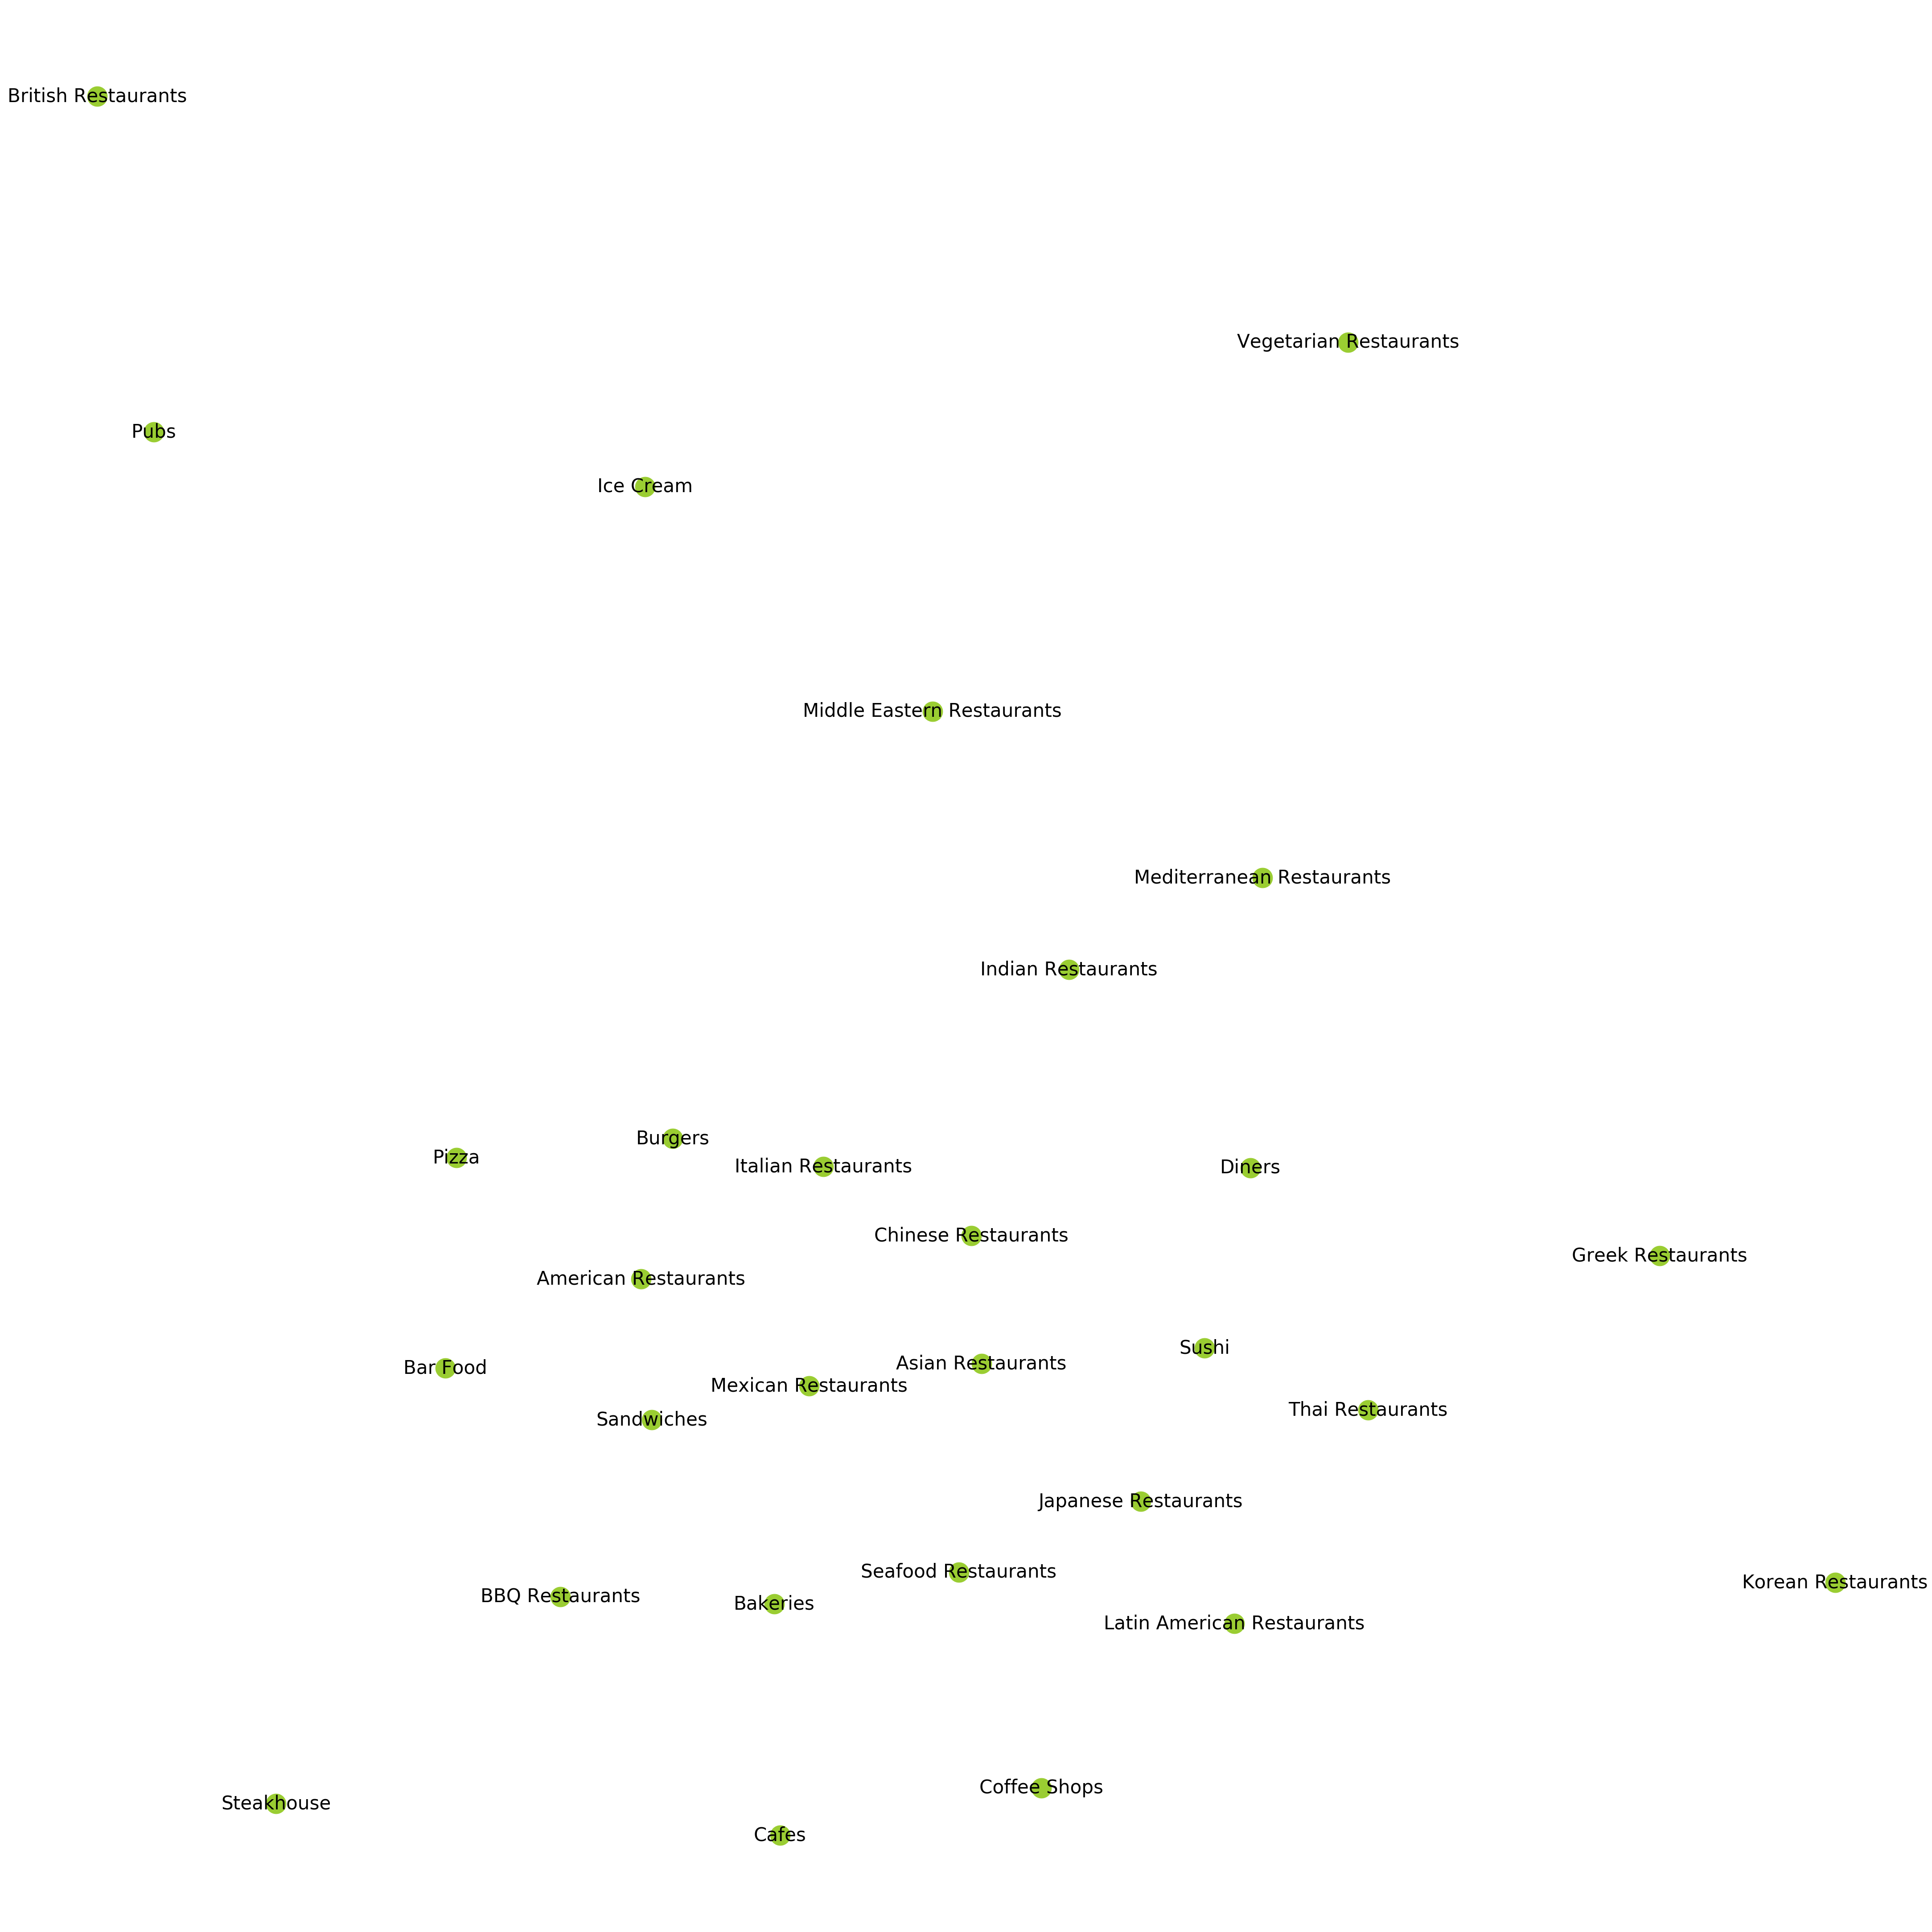

In [134]:
'''
    Network graph: WITHOUT edges
'''

plt.figure(figsize=(60, 60))
nx.draw(G, pos=pos, with_labels=True, node_color = 'yellowgreen', 
       edge_color = 'white', font_size = 42, node_size = 2000) # width=5, 
# plt.savefig('Graph_network_{}_without_edges.png'.format(category))
plt.show()
plt.close()


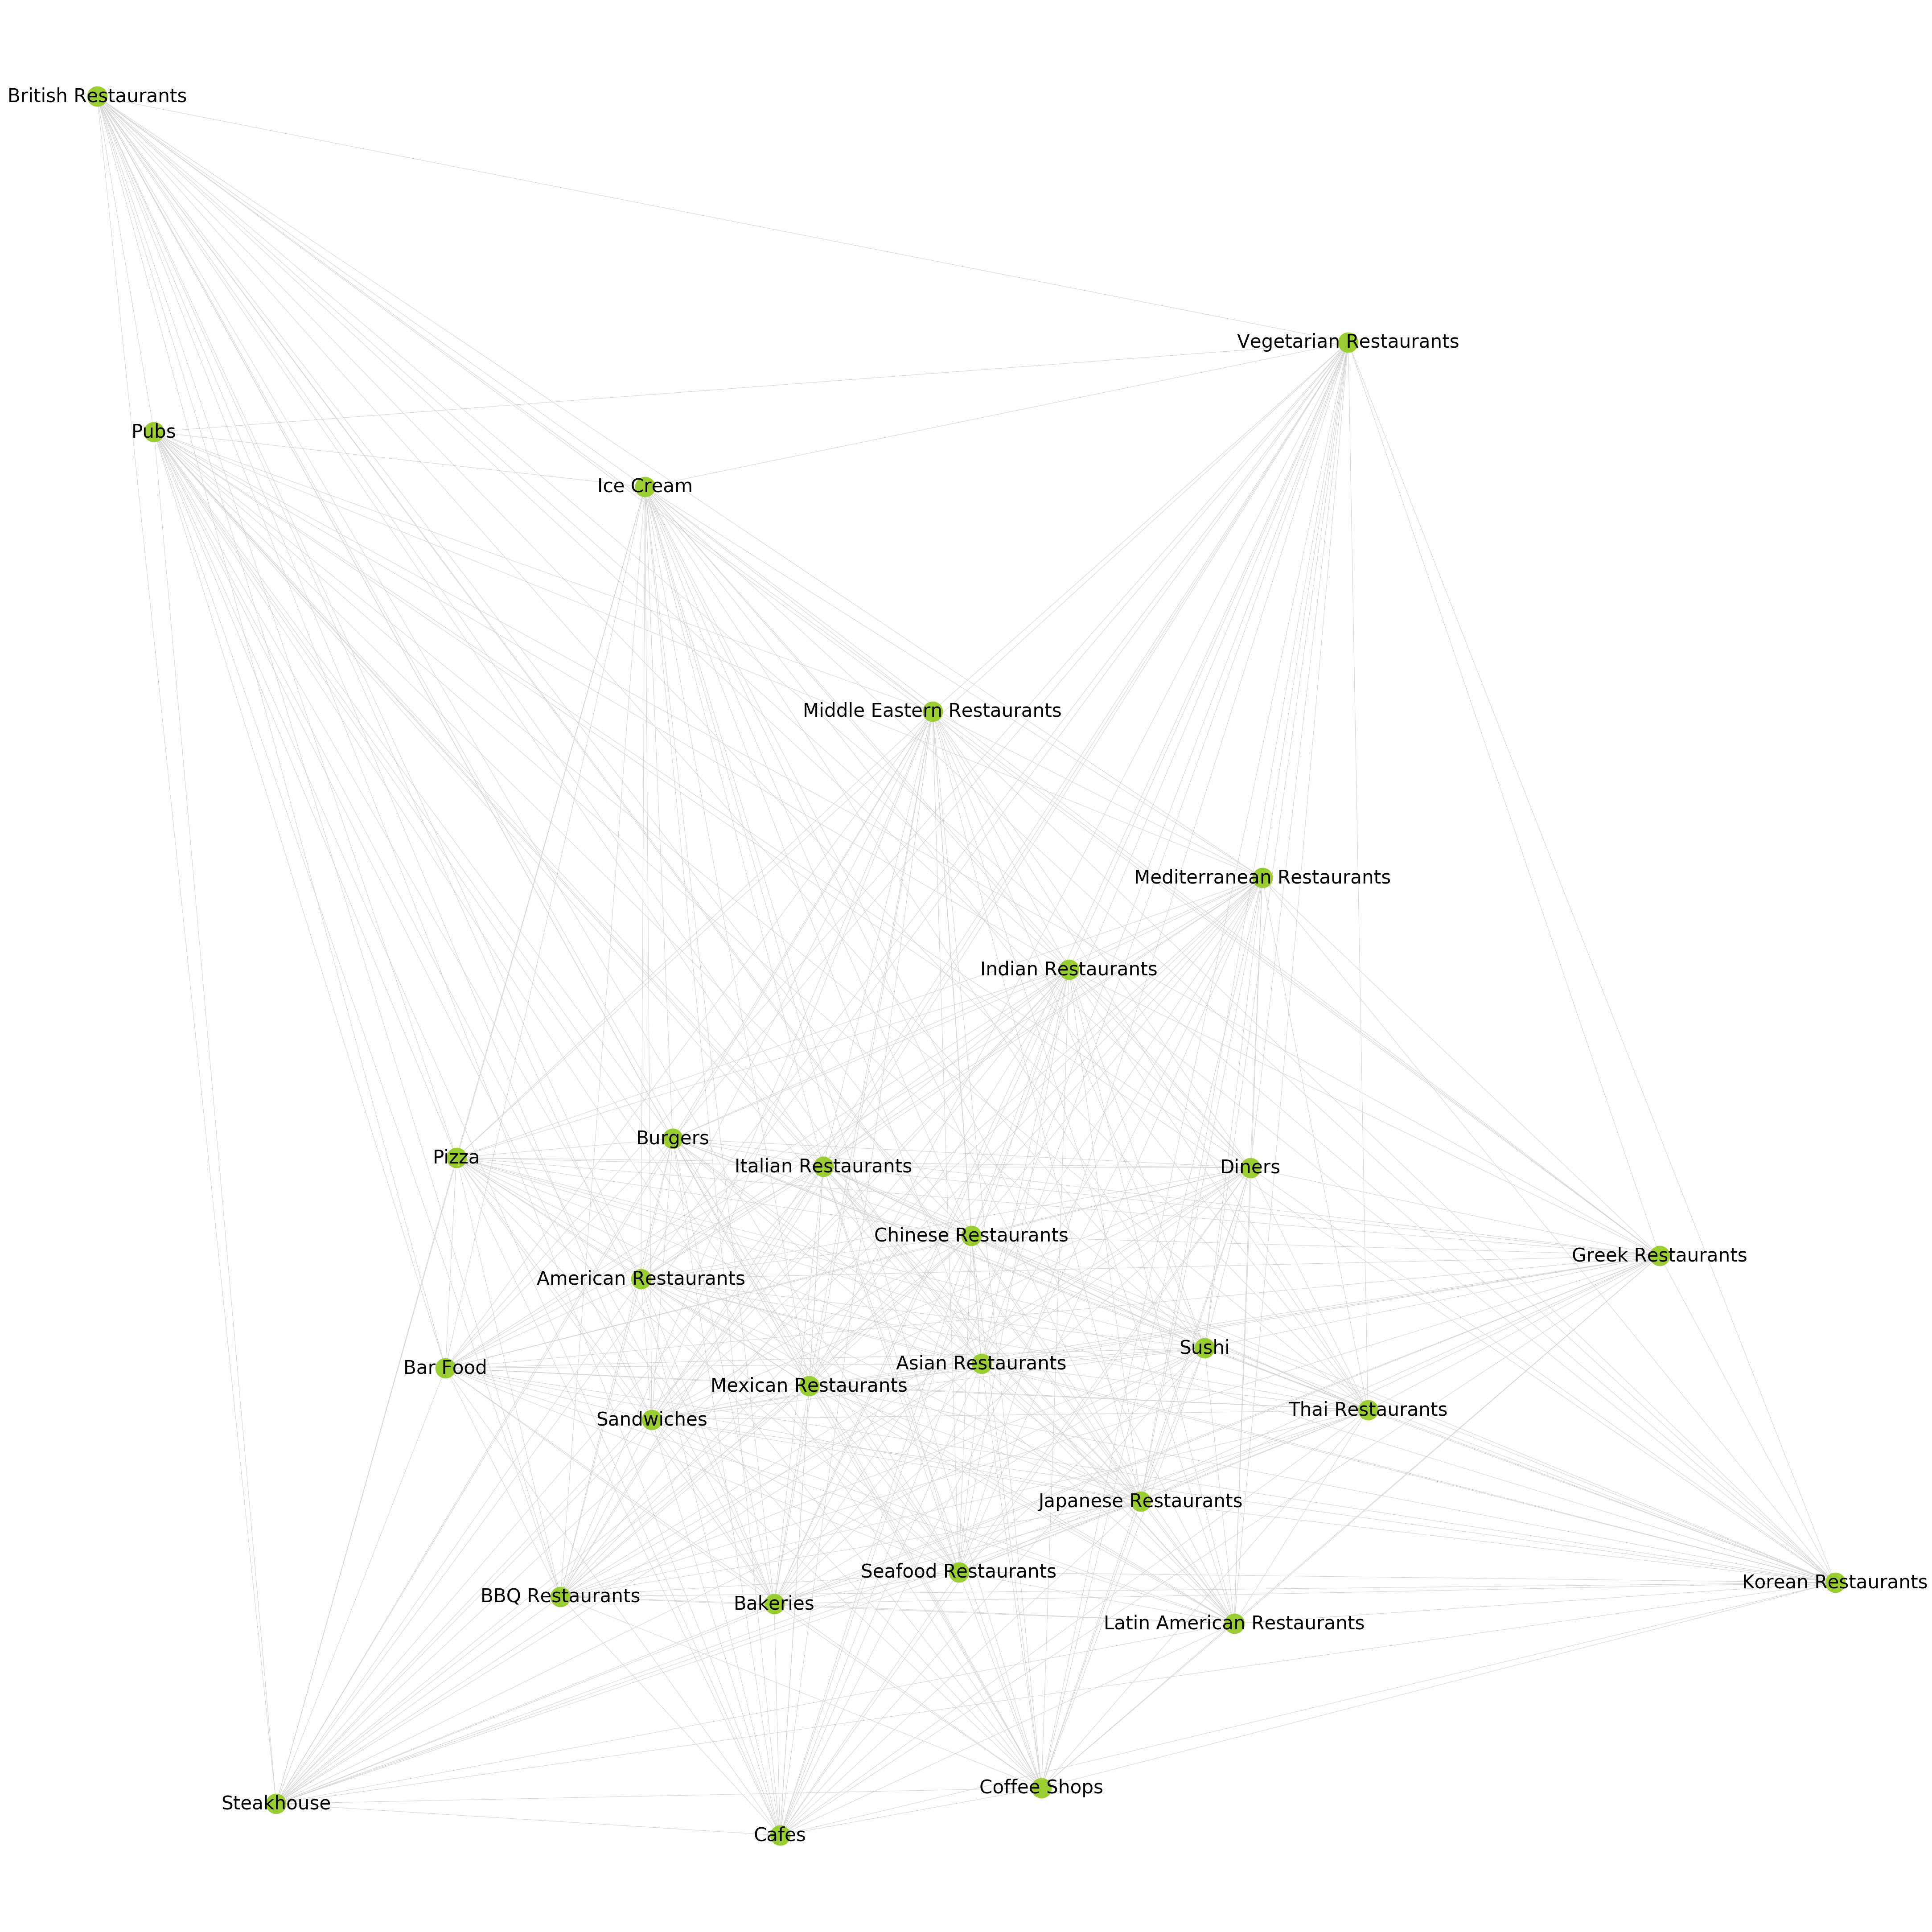

In [135]:
'''
    Network graph: WITH edges
'''

plt.figure(figsize=(60, 60))
nx.draw(G, pos=pos, with_labels=True, node_color = 'yellowgreen', 
       edge_color = 'lightgray', font_size = 42, node_size = 2000) # width=5, 
# plt.savefig('Graph_network_{}_with_edges.png'.format(category))
plt.show()
plt.close()
